# Interactive visualization of MPI simulaitons

In this example, which builds on our previous one of interactive MPI monitoring, we now demonstrate how to use the IPython data publication APIs.

## Load IPython support for working with MPI tasks

If you have not done so yet, use [the cluster tab in the Dashboard](/#tab2) to start your `mpi` cluster, it should be OK to leave the number of engines field empty (IPython will auto-detect the number of cores on your machine), unless you want to limit the run to use less cores than available in total.  Once your MPI cluster is running, you can proceed with the rest of the code.

We begin by creating a cluster client that gives us a local handle on the engines running in the (possibly remote) MPI cluster.  From the client we make a `view` object, which we set to use blocking mode by default as it is more convenient for interactive control.  Since the real computation will be done over MPI without IPython intervention, setting the default behavior to be blocking will have no significant performance impact.

**Note:** if on first try the following cell gives you an error message, wait a few seconds and run it again. It's possible that the system is simply initializing all your MPI engines, which may take a bit of time to be completely ready if you hadn't used any MPI libraries recently and the disk cache is cold.

In [1]:
from IPython.parallel import Client, error
cluster = Client(profile="mpi")
view = cluster[:]
view.block = True

Let's also load the plotting and numerical libraries so we have them ready for visualization later on.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Now, we load the MPI libraries into the engine namespaces, and do a simple printing of their MPI rank information to verify that all nodes are operational and they match our cluster's real capacity.  

Here, we are making use of IPython's special `%%px` cell magic, which marks the entire cell for parallel execution.  This means that the code below will not run in this notebook's kernel, but instead will be sent to *all* engines for execution there.  In this way, IPython makes it very natural to control your entire cluster from within the notebook environment:

In [3]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
# Load data publication API so engines can send data to notebook client
from IPython.kernel.zmq.datapub import publish_data
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 0/4
[stdout:1] MPI rank: 1/4
[stdout:2] MPI rank: 2/4
[stdout:3] MPI rank: 3/4


We write a utility that reorders a list according to the mpi ranks of the engines, since all gather operations will return data in engine id order, not in MPI rank order.  We'll need this later on when we want to reassemble in IPython data structures coming from all the engines: IPython will collect the data ordered by engine ID, but our code creates data structures based on MPI rank, so we need to map from one indexing scheme to the other.  This simple function does the job:

In [4]:
ranks = view['rank']
engine_mpi = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in engine_mpi]

## MPI simulation example

This is our 'simulation', a toy example that computes $\sin(f(x^2+y^2))$ for a slowly increasing frequency $f$ over a gradually refined mesh.  In a real-world example, there typically is a 'simulate' method that, afer setting up initial parameters, runs the entire computation.  But having this simple example will be sufficient to see something that changes visually as the computation evolves and that is quick enough for us to test.

And while simple, this example has a realistic decomposition of the spatial domain in one array per MPI node that requires care in reordering the data for visualization, as would be needed in a real-world application (unless your code accumulates data in the rank 0 node that you can grab directly).

In [5]:
%%px

# Global flag in the namespace
stop = False

def simulation(nsteps=100, delay=0.1):
    """Toy simulation code, computes sin(f*(x**2+y**2)) for a slowly increasing f
    over an increasingly fine mesh.

    The purpose of this code is simply to illustrate the basic features of a typical
    MPI code: spatial domain decomposition, a solution which is evolving in some 
    sense, and local per-node computation.  In this case the nodes only communicate when 
    gathering results for publication."""
    # Problem geometry
    xmin, xmax = 0, np.pi
    ymin, ymax = 0, 2*np.pi
    dy = (ymax-ymin)/mpi.size

    freqs = np.linspace(0.6, 1, nsteps)
    for j in range(nsteps):
        nx, ny = 2+j/4, 2+j/2/mpi.size
        nyt = mpi.size*ny
        Xax = np.linspace(xmin, xmax, nx)
        Yax = np.linspace(ymin+rank*dy, ymin+(rank+1)*dy, ny, endpoint=rank==mpi.size)
        X, Y = np.meshgrid(Xax, Yax)
        f = freqs[j]
        Z = np.cos(f*(X**2 + Y**2))
        
        # We are now going to publish data to the clients. We take advantage of fast
        # MPI communications and gather the Z mesh at the rank 0 node in the Zcat variable:
        Zcat = mpi.gather(Z, root=0)
        if mpi.rank == 0:
            # Then we use numpy's concatenation to construct a single numpy array with the
            # full mesh that can be sent to the client for visualization:
            Zcat = np.concatenate(Zcat)
            # We now can send a dict with the variables we want the client to have access to:
            publish_data(dict(Z=Zcat, nx=nx, nyt=nyt, j=j, nsteps=nsteps))
            
        # We add a small delay to simulate that a real-world computation
        # would take much longer, and we ensure all nodes are synchronized
        time.sleep(delay)
        # The stop flag can be set remotely via IPython, allowing the simulation to be
        # cleanly stopped from the outside
        if stop:
            break

## IPython tools to interactively monitor and plot the MPI results

We now define a local (to this notebook) plotting function that fetches data from the engines' global namespace.  Once it has retrieved the current state of the relevant variables, it produces and returns a figure:

In [6]:
from IPython.display import clear_output

def plot_current_results(ar, in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    ar : async result object

    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    # Read data from MPI rank 0 engine
    data = ar.data[engine_mpi[0]]
    
    try:
        nx, nyt, j, nsteps = [data[k] for k in ['nx', 'nyt', 'j', 'nsteps']]
        Z = data['Z']
    except KeyError:
        # This can happen if we read from the engines so quickly that the data 
        # hasn't arrived yet.
        fig, ax = plt.subplots()
        ax.plot([])
        ax.set_title("No data yet")
        display(fig)
        return fig
    else:
    
        fig, ax = plt.subplots()
        ax.contourf(Z)
        ax.set_title('Mesh: %i x %i, step %i/%i' % (nx, nyt, j+1, nsteps))
        axis('off')
        # We clear the notebook output before plotting this if in-place 
        # plot updating is requested
        if in_place:
            clear_output()
        display(fig)
        
        return fig

Finally, this is a convenience wrapper around the plotting code so that we can interrupt monitoring at any point, and that will provide basic timing information:

In [7]:
def monitor_simulation(ar, refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    ar : async result object

    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if ar.ready():
        plot_current_results(ar, in_place=plots_in_place)
        plt.close('all')
        print 'Simulation has already finished, no monitoring to do.'
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while not ar.ready():
            fig = plot_current_results(ar, in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh)
    except (KeyboardInterrupt, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output()
        plt.close('all')
        display(fig)
    print msg
    print 'Monitored for: %s.' % tmon

## Interactive monitoring in the client of the published data

Now, we can monitor the published data. We submit the simulation for execution as an asynchronous task, and then monitor this task at any frequency we desire.

In [11]:
# Create the local client that controls our IPython cluster with MPI support
from IPython.parallel import Client
cluster = Client(profile="mpi")
# We make a view that encompasses all the engines
view = cluster[:]
# And now we call on all available nodes our simulation routine,
# as an asynchronous task
nsteps = 10
delay = 0.1
ar = view.apply_async(lambda : simulation(nsteps, delay))

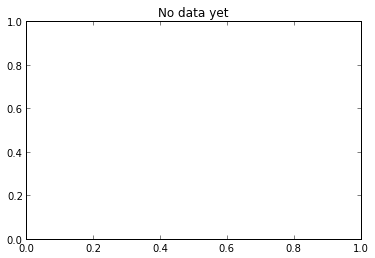

Simulation has already finished, no monitoring to do.


In [12]:
monitor_simulation(ar, refresh=1)